In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import os
from collections import defaultdict # For easier subject counts
import operator
from tqdm.notebook import tqdm

# Optional: for better display in Jupyter
from IPython.display import display

Generates Students - assigns college and subject to each student. Loads data and subject effects file. For each student, we generate a random group size number between 4 and 10. We adapt this number based upon their subject. We also generate the gender of each student following key demographic information.  

In [2]:
# Load the datasets
try:
    traits_df = pd.read_csv("Subjecteffects.csv")
    df = pd.read_csv("Student_num_data.csv")
except FileNotFoundError:
    print("Make sure 'Subjecteffects.csv' and 'Student_num_data.csv' are in the same directory.")
    exit()


# Clean column names
df.columns = [col.strip().replace(":", "") for col in df.columns]

# --- Main Student Generation ---

students = []
student_id_counter = 0

# Updated rules: Removed 5th and 6th years
subject_year_rules = {
    "Engineering Tripos": [1, 2, 3, 4],
    "Classical Tripos Four Year": [1, 2, 3, 4],
    "Chem Eng via Engineering": [1, 2, 3, 4],
    "Chem Eng via Nat Sciences": [1, 2, 3, 4],
    "Mathematical Tripos": [1, 2, 3, 4],
    "Natural Sciences Tripos": [1, 2, 3, 4],
    "Mod & Med Langs Tripos": [1, 2, 4],  # no 3rd year
    "History and Mod Lang Tripos": [1, 2, 4],  # no 3rd year
    "Veterinary Medicine": [1, 2, 3, 4], # Capped at 4 years
    "Medicine": [1, 2, 3, 4] # Capped at 4 years
}

fourth_year_probs = {
    "Chem Eng via Nat Sciences": 0.7,
    "Mathematical Tripos": 0.3,
    "Natural Sciences Tripos": 0.7
}

# Generate base student data
for _, row in df.iterrows():
    college = row['College'].strip()
    course = row['Course'].strip()
    num_students = int(row['Number of Students'])

    years = subject_year_rules.get(course, [1, 2, 3]) # Default to 3 years if not specified

    for year in years:
        if year == 4 and course in fourth_year_probs:
            num_year_students = int(num_students * fourth_year_probs[course])
        else:
            # For years 1, 2, 3, we assume a full cohort.
            # For year 4 in courses without special probability, also assume full cohort.
            num_year_students = num_students

        for _ in range(num_year_students):
            student = {
                "Student ID": f"{student_id_counter:06d}",
                "College": college,
                "Subject": course,
                "Year": year,
                "Social Propensity": 0,
                "Club Propensity": 0,
                "Disease State": 0
            }
            students.append(student)
            student_id_counter += 1

students_df = pd.DataFrame(students)

# --- Trait Generation ---

# Create dictionaries for quick lookup from the traits dataframe
adaption_dict = dict(zip(traits_df['Subject'], traits_df['Group Adaption size']))
female_prob_dict = dict(zip(traits_df['Subject'], traits_df['Female Probability']))

def sample_group_size():
    """Samples a group size from a normal distribution with cutoffs."""
    while True:
        size = np.random.normal(loc=7, scale=1.5)
        if 4 <= size <= 12:
            return size

def generate_traits(row):
    """Generates traits for a student, including gender and group size."""
    subject = row['Subject']
    college = row['College']

    # Adapted group size
    base_group_size = int(sample_group_size())
    adaption = adaption_dict.get(subject, 1) # Default adaption of 1
    adapted_group_size = base_group_size + adaption

    # Gender assignment with college-specific rules
    if college in ["Newnham", "Murray Edwards"]:
        gender = 'Female'
    else:
        female_prob = female_prob_dict.get(subject, 0.5)  # Default to 0.5 if subject not in dict
        gender = 'Female' if np.random.rand() < female_prob else 'Male'

    return pd.Series({
        'Adapted Group Size': adapted_group_size,
        'Gender': gender
    })

# Apply the function to generate traits
students_df[['Adapted Group Size', 'Gender']] = students_df.apply(generate_traits, axis=1)

# Save the final dataframe
students_df.to_csv("students_full_network.csv", index=False)
print(len(students_df))


11411


I will now generate a list of groups, each with a group size, a list of students in the group, and a group ID. <br>
Group Assumptions/Aims: Most groups are single year, most groups are single college, most groups are mixed gender, most groups have a diverse subject mix. That being said, it more likely to be friends with same year group, same subject, same course, and same gender. Additionaly, higher years are more likely to be friends with people that are not similar to them. 

In [3]:
#This is the dynamic probability function that determines the likelihood of a friend entering a friend group.
def candidate_prob(s, base_subj, base_col, base_yr, base_gen,
                   current_unassigned_count,
                   base_yr_unassigned_count,
                   base_col_unassigned_count,
                   base_subj_unassigned_count):

    prob = 0.000000000000001 # Extremely low base probability

    # --- Adaptation Factors ---
    year_desperation_factor = 1.0
    if current_unassigned_count > 0 and base_yr_unassigned_count > 0:
        if base_yr_unassigned_count / current_unassigned_count < 0.1:
            year_desperation_factor = 1.0 + (1.0 - base_yr_unassigned_count / current_unassigned_count) * 2.0

    college_desperation_factor = 1.0
    if current_unassigned_count > 0 and base_col_unassigned_count > 0:
        if base_col_unassigned_count / current_unassigned_count < 0.1:
            college_desperation_factor = 1.0 + (1.0 - base_col_unassigned_count / current_unassigned_count) * 2.0

    # Higher Year Cross-Year Boost
    higher_year_cross_year_boost = 1.0
    if base_yr >= 3:
        higher_year_cross_year_boost = 1.0 + (base_yr - 2) * 1.5 # Multiplier from previous successful run


    if s['Year'] == base_yr:
        prob += 50.0 * year_desperation_factor
        if s['College'] == base_col:
            # Subject adjustments as they were in the previous successful version
            if s['Subject'] == base_subj:
                prob += 2.0 # Was 2.0 in the specific version that gave 5.61% single-subject
            else:
                prob += 1.0 # Was 1.0 in that version
        else:  # Same year, but different college
            prob_boost = 100.0
            prob += prob_boost * college_desperation_factor
            # Subject adjustments
            if s['Subject'] == base_subj:
                prob += 1.0 # Was 1.0 in that version
            else:
                prob += 0.5 # Was 0.5 in that version
    else:  # Different year (value from previous successful run)
        base_cross_year_prob = 1.0 # Was 1.0 in the specific version that gave 0.05% multi-year
        prob += base_cross_year_prob * year_desperation_factor * higher_year_cross_year_boost

        if s['College'] == base_col:
            prob += 0.005 * college_desperation_factor # Was 0.005

    # --- GENDER PREFERENCE (COMPLETELY REMOVED) ---
    # The influence of gender is removed to allow for natural mixing.

    return max(0, prob)

In [4]:
full_path = r"C:\Users\joshu\Documents\Cambridge\3rd Year Work\NetDisFri\students_full_network.csv" #load data in case of variable name change. 

try:
    students_full_df = pd.read_csv(full_path, index_col=0)
    print(f"Successfully loaded full student data from: {full_path}")
except FileNotFoundError:
    print(f"Error: The file '{full_path}' was not found. Please ensure it is uploaded to the environment.")
    exit()

# --- USE THE FULL DATASET FROM NOW ON ---
students_df = students_full_df.copy()
students_df['Assigned'] = False

groups = []
group_id_counter = 1
start_time = time.time()

# --- GROUP FORMATION ALGORITHM: Hierarchical Filtering with Adaptive Probabilities (unchanged logic) ---
while students_df[~students_df['Assigned']].shape[0] > 0:
    base_idx = students_df[~students_df['Assigned']].index[0]
    base_student = students_df.loc[base_idx]
    
    target_group_size = max(3, int(round(base_student['Adapted Group Size'])))
    
    group_members = [base_idx]
    
    base_subj = base_student['Subject']
    base_col = base_student['College']
    base_yr = base_student['Year']
    base_gen = base_student['Gender']

    # --- Calculate dynamic pool statistics for this iteration ---
    unassigned_pool = students_df[~students_df['Assigned']]
    current_unassigned_count = len(unassigned_pool)

    base_yr_unassigned_count = len(unassigned_pool[unassigned_pool['Year'] == base_yr])
    base_col_unassigned_count = len(unassigned_pool[unassigned_pool['College'] == base_col])
    base_subj_unassigned_count = len(unassigned_pool[unassigned_pool['Subject'] == base_subj])


    # --- Hierarchical Selection ---
    
    # Tier 1: Same Year & Same College
    candidates_tier1 = students_df[
        (~students_df['Assigned']) &
        (students_df.index != base_idx) &
        (students_df['Year'] == base_yr) &
        (students_df['College'] == base_col)
    ].copy()

    if len(group_members) < target_group_size and not candidates_tier1.empty:
        candidates_tier1['Prob'] = candidates_tier1.apply(
            lambda s: candidate_prob(s, base_subj, base_col, base_yr, base_gen,
                                    current_unassigned_count, base_yr_unassigned_count,
                                    base_col_unassigned_count, base_subj_unassigned_count), axis=1
        )
        # Dynamic subject diversity adjustment (retained as it was in that successful version)
        current_group_subjects = students_df.loc[group_members, 'Subject'].tolist()
        if len(current_group_subjects) > 0 and len(set(current_group_subjects)) == 1:
            dominant_subject = current_group_subjects[0]
            for idx in candidates_tier1.index:
                if candidates_tier1.loc[idx, 'Subject'] == dominant_subject:
                    candidates_tier1.loc[idx, 'Prob'] *= 0.1 # This was 0.1
                else:
                    candidates_tier1.loc[idx, 'Prob'] *= 2.0 # This was 2.0
            candidates_tier1['Prob'] = candidates_tier1['Prob'].apply(lambda p: max(0.000000000000001, p))


        candidates_tier1 = candidates_tier1.sort_values(by='Prob', ascending=False)
        
        num_to_select = target_group_size - len(group_members)
        selected_from_tier1 = candidates_tier1.head(num_to_select).index.tolist()
        group_members.extend(selected_from_tier1)

    # Tier 2: Same Year (Any College)
    if len(group_members) < target_group_size:
        candidates_tier2 = students_df[
            (~students_df['Assigned']) &
            (students_df.index.isin(group_members) == False) &
            (students_df['Year'] == base_yr)
        ].copy()

        if not candidates_tier2.empty:
            candidates_tier2['Prob'] = candidates_tier2.apply(
                lambda s: candidate_prob(s, base_subj, base_col, base_yr, base_gen,
                                        current_unassigned_count, base_yr_unassigned_count,
                                        base_col_unassigned_count, base_subj_unassigned_count), axis=1
            )
            # Dynamic subject diversity adjustment
            current_group_subjects = students_df.loc[group_members, 'Subject'].tolist()
            if len(current_group_subjects) > 0 and len(set(current_group_subjects)) == 1:
                dominant_subject = current_group_subjects[0]
                for idx in candidates_tier2.index:
                    if candidates_tier2.loc[idx, 'Subject'] == dominant_subject:
                        candidates_tier2.loc[idx, 'Prob'] *= 0.1
                    else:
                        candidates_tier2.loc[idx, 'Prob'] *= 2.0
                candidates_tier2['Prob'] = candidates_tier2['Prob'].apply(lambda p: max(0.000000000000001, p))

            candidates_tier2 = candidates_tier2.sort_values(by='Prob', ascending=False)
            
            num_to_select = target_group_size - len(group_members)
            selected_from_tier2 = candidates_tier2.head(num_to_select).index.tolist()
            group_members.extend(selected_from_tier2)

    # Tier 3: Same College (Any Year)
    if len(group_members) < target_group_size:
        candidates_tier3 = students_df[
            (~students_df['Assigned']) &
            (students_df.index.isin(group_members) == False) &
            (students_df['College'] == base_col)
        ].copy()

        if not candidates_tier3.empty:
            candidates_tier3['Prob'] = candidates_tier3.apply(
                lambda s: candidate_prob(s, base_subj, base_col, base_yr, base_gen,
                                        current_unassigned_count, base_yr_unassigned_count,
                                        base_col_unassigned_count, base_subj_unassigned_count), axis=1
            )
            # Dynamic subject diversity adjustment
            current_group_subjects = students_df.loc[group_members, 'Subject'].tolist()
            if len(current_group_subjects) > 0 and len(set(current_group_subjects)) == 1:
                dominant_subject = current_group_subjects[0]
                for idx in candidates_tier3.index:
                    if candidates_tier3.loc[idx, 'Subject'] == dominant_subject:
                        candidates_tier3.loc[idx, 'Prob'] *= 0.1
                    else:
                        candidates_tier3.loc[idx, 'Prob'] *= 2.0
                candidates_tier3['Prob'] = candidates_tier3['Prob'].apply(lambda p: max(0.000000000000001, p))

            candidates_tier3 = candidates_tier3.sort_values(by='Prob', ascending=False)
            
            num_to_select = target_group_size - len(group_members)
            selected_from_tier3 = candidates_tier3.head(num_to_select).index.tolist()
            group_members.extend(selected_from_tier3)
            
    # Final Fallback: Fill with any remaining unassigned students
    if len(group_members) < target_group_size:
        num_to_fill_randomly = target_group_size - len(group_members)
        
        remaining_unassigned_indices = students_df[~students_df['Assigned'] & ~students_df.index.isin(group_members)].index.tolist()
        
        if len(remaining_unassigned_indices) > 0:
            np.random.shuffle(remaining_unassigned_indices)
            group_members.extend(remaining_unassigned_indices[:num_to_fill_randomly])

    # Ensure the final group size meets the minimum requirement of 3
    final_group_size = max(3, len(group_members))
    
    # Update students DataFrame
    students_df.loc[group_members, 'Assigned'] = True
    students_df.loc[group_members, 'Group ID'] = group_id_counter
    students_df.loc[group_members, 'Group Size'] = final_group_size

    # Store group details
    groups.append({
        'Group ID': group_id_counter,
        'Group Size': final_group_size,
        'Members': group_members
    })
    
    group_id_counter += 1

    # Print progress
    if group_id_counter % 1000 == 0:
        elapsed = time.time() - start_time
        assigned = students_df['Assigned'].sum()
        print(f"Groups formed: {group_id_counter-1}. Assigned students: {assigned}. Time: {elapsed:.2f}s")

#Produces students_df
#Converts into a csv file.
students_df.to_csv("base_group_formations.csv", index=False)
print(students_df.head().to_markdown(index=False))

Successfully loaded full student data from: C:\Users\joshu\Documents\Cambridge\3rd Year Work\NetDisFri\students_full_network.csv
Groups formed: 999. Assigned students: 6109. Time: 28.57s
| College   | Subject             |   Year |   Social Propensity |   Club Propensity |   Disease State |   Adapted Group Size | Gender   | Assigned   |   Group ID |   Group Size |
|:----------|:--------------------|-------:|--------------------:|------------------:|----------------:|---------------------:|:---------|:-----------|-----------:|-------------:|
| Christ's  | Architecture Tripos |      1 |                   0 |                 0 |               0 |                    6 | Male     | True       |          1 |            6 |
| Christ's  | Architecture Tripos |      1 |                   0 |                 0 |               0 |                    4 | Male     | True       |          2 |            4 |
| Christ's  | Architecture Tripos |      2 |                   0 |                 0 |       

Runs group analysis to determine key parameters:

In [5]:
print(students_df.columns)

Index(['College', 'Subject', 'Year', 'Social Propensity', 'Club Propensity',
       'Disease State', 'Adapted Group Size', 'Gender', 'Assigned', 'Group ID',
       'Group Size'],
      dtype='object')


In [6]:
def analyze_group_formation(students_df: pd.DataFrame) -> str:
    """
    Analyzes the formation of student groups from a DataFrame and returns a descriptive report.

    This function takes a DataFrame containing student data with assigned group IDs and
    generates a multi-part text report detailing the characteristics of the formed groups.
    The analysis covers group sizes, diversity across year, college, gender, and subject.

    Args:
        students_df (pd.DataFrame): A DataFrame with student and group information.
                                    It must contain the following columns:
                                    - 'Group ID': The identifier for the group.
                                    - 'Group Size': The total number of members in the group.
                                    - 'Assigned': A boolean indicating if the student is assigned.
                                    - 'Year': The student's academic year.
                                    - 'College': The student's college affiliation.
                                    - 'Gender': The student's gender.
                                    - 'Subject': The student's academic subject.

    Returns:
        str: A formatted string containing the full analysis report of the group formation.
    """
    if not isinstance(students_df, pd.DataFrame):
        return "Error: Input must be a pandas DataFrame."

    required_columns = {'Group ID', 'Group Size', 'Assigned', 'Year', 'College', 'Gender', 'Subject'}
    if not required_columns.issubset(students_df.columns):
        missing = required_columns - set(students_df.columns)
        return f"Error: The input DataFrame is missing the following required columns: {missing}"

    report_parts = []

    # Reconstruct groups for analysis
    reconstructed_groups = []
    # Ensure unique groups are processed, even if 'Group ID' is not sorted
    unique_group_ids = students_df['Group ID'].unique()
    for group_id in unique_group_ids:
        group_members_df = students_df[students_df['Group ID'] == group_id]
        if not group_members_df.empty:
            reconstructed_groups.append({
                'Group ID': group_id,
                'Members_DF': group_members_df
            })
    
    total_groups = len(reconstructed_groups)

    # --- Overall Summary ---
    report_parts.append(f"--- Group Formation Complete (Total Students: {len(students_df)}) ---")
    report_parts.append(f"Total groups formed: {total_groups}")
    report_parts.append(f"All students assigned: {students_df['Assigned'].all()}")

    # --- Group Size Distribution ---
    report_parts.append("\n--- Group Size Distribution ---")
    size_distribution = students_df['Group Size'].value_counts().sort_index()
    report_parts.append(size_distribution.to_string())

    # --- Cross-Year Grouping Analysis ---
    year_diversity = [g['Members_DF']['Year'].nunique() for g in reconstructed_groups]
    num_multi_year_groups = sum(1 for diversity in year_diversity if diversity > 1)
    percentage_multi_year = (num_multi_year_groups / total_groups) * 100 if total_groups > 0 else 0
    report_parts.append("\n--- Cross-Year Grouping Analysis ---")
    report_parts.append(f"Number of groups spanning multiple years: {num_multi_year_groups} out of {total_groups} total groups.")
    report_parts.append(f"Percentage of multi-year groups: {percentage_multi_year:.2f}%")

    # --- Cross-College Grouping Analysis ---
    college_diversity = [g['Members_DF']['College'].nunique() for g in reconstructed_groups]
    num_multi_college_groups = sum(1 for diversity in college_diversity if diversity > 1)
    percentage_multi_college = (num_multi_college_groups / total_groups) * 100 if total_groups > 0 else 0
    report_parts.append("\n--- Cross-College Grouping Analysis ---")
    report_parts.append(f"Number of groups spanning multiple colleges: {num_multi_college_groups} out of {total_groups} total groups.")
    report_parts.append(f"Percentage of multi-college groups: {percentage_multi_college:.2f}%")

    # --- Gender Grouping Analysis ---
    single_gender_groups = 0
    mixed_gender_male_counts, mixed_gender_female_counts = [], []
    for group in reconstructed_groups:
        genders_in_group = group['Members_DF']['Gender'].nunique()
        if genders_in_group == 1:
            single_gender_groups += 1
        else:
            gender_counts = group['Members_DF']['Gender'].value_counts()
            mixed_gender_male_counts.append(gender_counts.get('Male', 0))
            mixed_gender_female_counts.append(gender_counts.get('Female', 0))

    mixed_gender_groups = total_groups - single_gender_groups
    percentage_single_gender = (single_gender_groups / total_groups) * 100 if total_groups > 0 else 0
    percentage_mixed_gender = (mixed_gender_groups / total_groups) * 100 if total_groups > 0 else 0
    report_parts.append("\n--- Gender Grouping Analysis ---")
    report_parts.append(f"Number of single-gender groups: {single_gender_groups} out of {total_groups} total groups.")
    report_parts.append(f"Percentage of single-gender groups: {percentage_single_gender:.2f}%")
    report_parts.append(f"Number of mixed-gender groups: {mixed_gender_groups} out of {total_groups} total groups.")
    report_parts.append(f"Percentage of mixed-gender groups: {percentage_mixed_gender:.2f}%")
    
    if mixed_gender_groups > 0:
        avg_males_in_mixed = np.mean(mixed_gender_male_counts)
        avg_females_in_mixed = np.mean(mixed_gender_female_counts)
        report_parts.append(f"Average Males in mixed-gender groups: {avg_males_in_mixed:.2f}")
        report_parts.append(f"Average Females in mixed-gender groups: {avg_females_in_mixed:.2f}")
    else:
        report_parts.append("No mixed-gender groups found for average calculation.")

    # --- Subject Grouping Analysis ---
    subject_diversity, dominant_subject_proportions = [], []
    for group in reconstructed_groups:
        group_df = group['Members_DF']
        subject_diversity.append(group_df['Subject'].nunique())
        if not group_df.empty:
            dominant_proportion = group_df['Subject'].value_counts().max() / len(group_df)
            dominant_subject_proportions.append(dominant_proportion)
        else:
            dominant_subject_proportions.append(0.0)

    single_subject_groups = sum(1 for d in subject_diversity if d == 1)
    multi_subject_groups = total_groups - single_subject_groups
    percentage_single_subject = (single_subject_groups / total_groups) * 100 if total_groups > 0 else 0
    percentage_multi_subject = (multi_subject_groups / total_groups) * 100 if total_groups > 0 else 0
    avg_unique_subjects_per_group = np.mean(subject_diversity) if subject_diversity else 0
    max_unique_subjects_per_group = np.max(subject_diversity) if subject_diversity else 0
    avg_dominant_subject_proportion = np.mean(dominant_subject_proportions) if dominant_subject_proportions else 0
    
    report_parts.append("\n--- Subject Grouping Analysis ---")
    report_parts.append(f"Number of single-subject groups: {single_subject_groups} out of {total_groups} total groups.")
    report_parts.append(f"Percentage of single-subject groups: {percentage_single_subject:.2f}%")
    report_parts.append(f"Number of multi-subject groups: {multi_subject_groups} out of {total_groups} total groups.")
    report_parts.append(f"Percentage of multi-subject groups: {percentage_multi_subject:.2f}%")
    report_parts.append(f"Average unique subjects per group: {avg_unique_subjects_per_group:.2f}")
    report_parts.append(f"Maximum unique subjects in a group: {max_unique_subjects_per_group}")
    report_parts.append(f"Average proportion of dominant subject in groups: {avg_dominant_subject_proportion:.2f}")

    return "\n".join(report_parts)

In [7]:
# --- Call the function and print the output ---
# The function returns a single string which we can then print to the console.
analysis_report = analyze_group_formation(students_df)
#print(analysis_report)

Note that the proportions are not quite what we want. So we use switching algorithm to alter groups to the desired traits. We do this by producing a class GroupOptimizer. 

In [8]:
# Cell 2: Define the Optimizer Class and All Helper Functions

class GroupOptimizer:
    """
    Optimizes student group assignments by iteratively swapping students
    to improve group diversity based on a defined set of criteria.
    """
    def __init__(self, students_df: pd.DataFrame, timeout_seconds: int = 2400):
        self.df = students_df.copy()
        self.timeout = timeout_seconds
        self.start_time = time.time()
        self.properties = self._initialize_properties()
        self.comparison_map = {'increase': operator.gt, 'decrease': operator.lt}
        
        # --- NEW: Initialize cache for subject density candidates ---
        self.subject_density_candidates = []

    def _initialize_properties(self) -> dict:
        print("Initializing group properties cache...")
        props = {}
        for group_id in self.df['Group ID'].unique():
            if group_id == -1: continue
            group_df = self.df[self.df['Group ID'] == group_id]
            props[group_id] = self._calculate_single_group_props(group_df)
        return props

    def _calculate_single_group_props(self, group_df: pd.DataFrame) -> dict:
        return {
            'members_ids': group_df.index.tolist(),
            'years_set': set(group_df['Year']),
            'colleges_set': set(group_df['College']),
            'genders_set': set(group_df['Gender']),
            'subjects_set': set(group_df['Subject']),
            'subject_counts': group_df['Subject'].value_counts().to_dict(),
            'size': len(group_df)
        }
        
    # --- NEW: Caching method to find and update problem groups for subject density ---
    def _update_subject_density_candidates(self, target_prop: float, group_ids: list = None):
        """
        Builds or updates the cache of groups that exceed the target dominant subject proportion.
        If group_ids is None, it builds the cache from scratch.
        If group_ids is a list, it only updates those specific groups.
        """
        groups_to_check = group_ids if group_ids is not None else self.properties.keys()
        
        if group_ids is not None:
            # If we are updating, remove the specified groups first to avoid duplicates
            self.subject_density_candidates = [gid for gid in self.subject_density_candidates if gid not in group_ids]

        for gid in groups_to_check:
            props = self.properties.get(gid)
            if not props or props['size'] == 0 or not props['subject_counts']:
                continue
            
            dominant_prop = max(props['subject_counts'].values()) / props['size']
            
            if dominant_prop > target_prop:
                self.subject_density_candidates.append(gid)

    def _update_properties_for_groups(self, group_ids: list):
        for group_id in group_ids:
            group_df = self.df[self.df['Group ID'] == group_id]
            self.properties[group_id] = self._calculate_single_group_props(group_df)

    def _get_global_stats(self) -> dict:
        # This function remains the same, used for reporting
        total_groups = len(self.properties)
        if total_groups == 0: return {}
        props_list = list(self.properties.values())
        num_multi_year = sum(1 for p in props_list if len(p['years_set']) > 1)
        num_multi_college = sum(1 for p in props_list if len(p['colleges_set']) > 1)
        num_single_gender = sum(1 for p in props_list if len(p['genders_set']) == 1)
        dominant_props = [max(p['subject_counts'].values()) / p['size'] if p['size'] > 0 and p['subject_counts'] else 0 for p in props_list]
        return {
            'multi_year_pct': (num_multi_year / total_groups) * 100,
            'multi_college_pct': (num_multi_college / total_groups) * 100,
            'single_gender_pct': (num_single_gender / total_groups) * 100,
            'avg_dominant_subject_prop': np.mean(dominant_props) if dominant_props else 0,
        }

    def _perform_swap(self, s1_id: int, s2_id: int):
        g1_id, g2_id = self.df.loc[s1_id, 'Group ID'], self.df.loc[s2_id, 'Group ID']
        self.df.loc[s1_id, 'Group ID'], self.df.loc[s2_id, 'Group ID'] = g2_id, g1_id

    def _execute_step(self, step_config: dict):
        # Unpack config
        name, metric, target, direction, max_swaps, max_stagnation = (
            step_config['name'], step_config['metric'], step_config['target'], 
            step_config['direction'], step_config['max_swaps'], step_config['max_stagnation']
        )
        find_candidates_func, find_partner_func = step_config['find_candidates_func'], step_config['find_partner_func']
        
        # --- CHANGED: If this is the subject density step, build the initial cache ---
        if name == "Decrease Subject Density":
            self._update_subject_density_candidates(target_prop=target)

        print(f"\n--- Running: {name} (Target for {metric}: {direction} to {target:.2f}) ---")
        swaps_performed, stagnation_counter = 0, 0
        current_metric_val = self._get_global_stats()[metric]
        is_improving = self.comparison_map[direction]

        with tqdm(total=max_swaps, desc=name, unit=" swaps") as pbar:
            postfix_data = {metric: f'{current_metric_val:.3f}', 'stagnation': stagnation_counter}
            pbar.set_postfix(postfix_data)

            while (is_improving(target, current_metric_val) and 
                   swaps_performed < max_swaps and 
                   stagnation_counter < max_stagnation):
                
                if time.time() - self.start_time > self.timeout:
                    print("  Timeout reached."); break

                # The candidate function now uses the cache for the subject density step
                s1_id = find_candidates_func(self)
                if not s1_id:
                    pbar.set_description(f"{name} (No candidates)"); break
                
                s2_id = find_partner_func(self, s1_id)

                if s2_id and s1_id != s2_id:
                    g1_id, g2_id = self.df.loc[s1_id, 'Group ID'], self.df.loc[s2_id, 'Group ID']
                    self._perform_swap(s1_id, s2_id)
                    self._update_properties_for_groups([g1_id, g2_id])
                    new_metric_val = self._get_global_stats()[metric]

                    if is_improving(new_metric_val, current_metric_val):
                        current_metric_val = new_metric_val
                        swaps_performed += 1
                        stagnation_counter = 0
                        pbar.update(1)
                        # --- CHANGED: Incrementally update the cache on success ---
                        if name == "Decrease Subject Density":
                            self._update_subject_density_candidates(target_prop=target, group_ids=[g1_id, g2_id])
                    else:
                        self._perform_swap(s1_id, s2_id) # Revert
                        self._update_properties_for_groups([g1_id, g2_id])
                        stagnation_counter += 1
                    
                    postfix_data = {metric: f'{current_metric_val:.3f}', 'stagnation': f'{stagnation_counter}/{max_stagnation}'}
                    pbar.set_postfix(postfix_data, refresh=True)
                else:
                    stagnation_counter += 1

            if stagnation_counter >= max_stagnation:
                print(f"  Stopping due to stagnation after {max_stagnation} failed attempts.")
        
        final_metric_val = self._get_global_stats()[metric]
        print(f"Finished '{name}'. Total swaps: {swaps_performed}. Final {metric}: {final_metric_val:.3f}")
        
    def run_optimization_pipeline(self, pipeline: list) -> pd.DataFrame:
        initial_stats = self._get_global_stats()
        print("\n--- Initial Group Demographics (Before Swaps) ---")
        for key, val in initial_stats.items(): print(f"{key}: {val:.3f}")
        for step_config in pipeline:
            self._execute_step(step_config)
        final_stats = self._get_global_stats()
        print("\n--- Final Group Demographics (After All Swaps) ---")
        for key, val in final_stats.items(): print(f"{key}: {val:.3f}")
        self.df['Group Size'] = self.df.groupby('Group ID')['Group ID'].transform('count')
        return self.df

# --- Helper Functions: One has been REMOVED and a NEW one ADDED ---

# REMOVED: find_students_in_dominant_subject (This slow function is no longer needed)

# NEW: This function is much faster as it just picks from the pre-computed cache.
def select_candidate_from_cached_list(optimizer: GroupOptimizer) -> int:
    """Selects a candidate student from a pre-cached list of high-density groups."""
    if not optimizer.subject_density_candidates:
        return None
    
    # Pick a random "problem group" from the cache
    target_gid = np.random.choice(optimizer.subject_density_candidates)
    
    # Get the details of that one group
    props = optimizer.properties[target_gid]
    dominant_subject = max(props['subject_counts'], key=props['subject_counts'].get)
    
    # Get members of that one group with the dominant subject
    dominant_subject_members = [
        sid for sid in props['members_ids'] 
        if optimizer.df.loc[sid, 'Subject'] == dominant_subject
    ]
    
    return np.random.choice(dominant_subject_members) if dominant_subject_members else None

# --- Other helper functions are unchanged ---
def find_students_in_single_year_groups(optimizer: GroupOptimizer) -> list:
    # This function now returns a single student ID, not a list
    single_year_gids = [gid for gid, p in optimizer.properties.items() if len(p['years_set']) == 1]
    if not single_year_gids: return None
    candidate_students = optimizer.df[optimizer.df['Group ID'].isin(single_year_gids)].index.tolist()
    return np.random.choice(candidate_students) if candidate_students else None

def find_year_crossover_partner(optimizer: GroupOptimizer, student_id: int) -> int:
    s_info = optimizer.df.loc[student_id]
    possible_partners = optimizer.df[(optimizer.df['Group ID'] != s_info['Group ID']) & (optimizer.df['Subject'] == s_info['Subject']) & (optimizer.df['Year'].isin([s_info['Year'] - 1, s_info['Year'] + 1]))]
    return np.random.choice(possible_partners.index) if not possible_partners.empty else None

def find_students_in_single_college_groups(optimizer: GroupOptimizer) -> int:
    # This function now returns a single student ID
    single_college_gids = [gid for gid, p in optimizer.properties.items() if len(p['colleges_set']) == 1]
    if not single_college_gids: return None
    candidate_students = optimizer.df[optimizer.df['Group ID'].isin(single_college_gids)].index.tolist()
    return np.random.choice(candidate_students) if candidate_students else None

def find_college_crossover_partner(optimizer: GroupOptimizer, student_id: int) -> int:
    s_info = optimizer.df.loc[student_id]
    possible_partners = optimizer.df[(optimizer.df['Group ID'] != s_info['Group ID']) & (optimizer.df['College'] != s_info['College']) & (optimizer.df['Year'] == s_info['Year']) & (optimizer.df['Subject'] == s_info['Subject'])]
    return np.random.choice(possible_partners.index) if not possible_partners.empty else None

def find_students_in_single_gender_groups(optimizer: GroupOptimizer) -> int:
    # This function now returns a single student ID
    single_gender_gids = [gid for gid, p in optimizer.properties.items() if len(p['genders_set']) == 1]
    if not single_gender_gids: return None
    candidate_students = optimizer.df[optimizer.df['Group ID'].isin(single_gender_gids)].index.tolist()
    return np.random.choice(candidate_students) if candidate_students else None

def find_gender_crossover_partner(optimizer: GroupOptimizer, student_id: int) -> int:
    s_info = optimizer.df.loc[student_id]
    possible_partners = optimizer.df[(optimizer.df['Group ID'] != s_info['Group ID']) & (optimizer.df['Gender'] != s_info['Gender']) & (optimizer.df['Year'] == s_info['Year']) & (optimizer.df['College'] == s_info['College'])]
    return np.random.choice(possible_partners.index) if not possible_partners.empty else None

def find_subject_diversity_partner(optimizer: GroupOptimizer, student_id: int) -> int:
    s_info = optimizer.df.loc[student_id]
    possible_partners = optimizer.df[(optimizer.df['Group ID'] != s_info['Group ID']) & (optimizer.df['Subject'] != s_info['Subject']) & (optimizer.df['Year'] == s_info['Year']) & (optimizer.df['College'] == s_info['College'])]
    return np.random.choice(possible_partners.index) if not possible_partners.empty else None

In [9]:
# Cell 3: Configure the Full Optimization Pipeline
#Adjust parameters here.
OPTIMIZATION_STEPS = [
    {
        'name': "Increase Cross-Year Diversity",
        'metric': 'multi_year_pct',
        'target': 3.0,
        'direction': 'increase',
        'max_swaps': 10000,
        'max_stagnation': 20000,
        'find_candidates_func': find_students_in_single_year_groups,
        'find_partner_func': find_year_crossover_partner,
    },
    {
        'name': "Increase Inter-College Diversity",
        'metric': 'multi_college_pct',
        'target': 5.0,
        'direction': 'increase',
        'max_swaps': 15000,
        'max_stagnation': 20000,
        'find_candidates_func': find_students_in_single_college_groups,
        'find_partner_func': find_college_crossover_partner,
    },
    {
        'name': "Decrease Single-Gender Groups",
        'metric': 'single_gender_pct',
        'target': 10.0,
        'direction': 'decrease',
        'max_swaps': 15000,
        'max_stagnation': 25000,
        'find_candidates_func': find_students_in_single_gender_groups,
        'find_partner_func': find_gender_crossover_partner,
    },
    {
        'name': "Decrease Subject Density",
        'metric': 'avg_dominant_subject_prop',
        'target': 0.33,
        'direction': 'decrease',
        'max_swaps': 20000,
        'max_stagnation': 30000,
        # --- CHANGED: Using the new, fast, cached candidate selection function ---
        'find_candidates_func': select_candidate_from_cached_list,
        'find_partner_func': find_subject_diversity_partner,
    },
]

In [10]:
print(students_df.columns)

Index(['College', 'Subject', 'Year', 'Social Propensity', 'Club Propensity',
       'Disease State', 'Adapted Group Size', 'Gender', 'Assigned', 'Group ID',
       'Group Size'],
      dtype='object')


In [11]:
# Cell 4: Load the Data

# Define the path to the data file
file_path = 'base_group_formations.csv'
data_loaded = False

try:
    # Check if 'students_df' already exists and is a DataFrame
    if 'students_df' in locals() and isinstance(students_df, pd.DataFrame):
        print("--- Using pre-existing 'students_df' DataFrame in memory. ---")
        if students_df.empty:
            print("Warning: The existing DataFrame is empty.")
        data_loaded = True
except NameError:
    # This will be caught if students_df is not defined
    pass

if not data_loaded:
    print(f"--- Attempting to load data from '{file_path}'. ---")
    try:
        students_df = pd.read_csv(file_path)
        print(f"Successfully loaded data from '{file_path}'.")
        data_loaded = True
    except FileNotFoundError:
        print(f"ERROR: The file '{file_path}' was not found.")
        print("Please ensure the CSV file is in the correct directory.")
        students_df = None # Ensure df is None if loading fails

if data_loaded and students_df is not None:
    display(students_df.head())

--- Using pre-existing 'students_df' DataFrame in memory. ---


,College,Subject,Year,Social Propensity,Club Propensity,Disease State,Adapted Group Size,Gender,Assigned,Group ID,Group Size
Student ID,,,,,,,,,,,
0,Christ's,Architecture Tripos,1,0,0,0,6,Male,True,1.0,6.0
1,Christ's,Architecture Tripos,1,0,0,0,4,Male,True,2.0,4.0
2,Christ's,Architecture Tripos,2,0,0,0,7,Female,True,3.0,7.0
3,Christ's,Architecture Tripos,2,0,0,0,8,Female,True,4.0,8.0
4,Christ's,Architecture Tripos,3,0,0,0,8,Male,True,5.0,8.0


In [12]:
print(students_df.columns)

Index(['College', 'Subject', 'Year', 'Social Propensity', 'Club Propensity',
       'Disease State', 'Adapted Group Size', 'Gender', 'Assigned', 'Group ID',
       'Group Size'],
      dtype='object')


In [13]:
# Cell 5: Run the Optimizer and Save the Output

if data_loaded and students_df is not None:
    # Initialize the optimizer with the loaded data
    optimizer = GroupOptimizer(students_df, timeout_seconds=3600) # Increased timeout for more steps
    
    # Run the full pipeline
    final_df = optimizer.run_optimization_pipeline(OPTIMIZATION_STEPS)

    # Save the final results
    output_filename = "students_groups_final.csv"
    final_df.to_csv(output_filename, index=False)
    
    print(f"\n✅ Optimization complete. Final data saved to '{output_filename}'")
    print("\n--- Head of the Final DataFrame ---")
    display(final_df.head())
else:
    print("\n--- Skipping execution because data could not be loaded. ---")

Initializing group properties cache...

--- Initial Group Demographics (Before Swaps) ---
multi_year_pct: 0.163
multi_college_pct: 3.848
single_gender_pct: 12.141
avg_dominant_subject_prop: 0.617

--- Running: Increase Cross-Year Diversity (Target for multi_year_pct: increase to 3.00) ---


Increase Cross-Year Diversity:   0%|          | 0/10000 [00:00<?, ? swaps/s]

Finished 'Increase Cross-Year Diversity'. Total swaps: 27. Final multi_year_pct: 3.089

--- Running: Increase Inter-College Diversity (Target for multi_college_pct: increase to 5.00) ---


Increase Inter-College Diversity:   0%|          | 0/15000 [00:00<?, ? swaps/s]

Finished 'Increase Inter-College Diversity'. Total swaps: 0. Final multi_college_pct: 6.667

--- Running: Decrease Single-Gender Groups (Target for single_gender_pct: decrease to 10.00) ---


Decrease Single-Gender Groups:   0%|          | 0/15000 [00:00<?, ? swaps/s]

Finished 'Decrease Single-Gender Groups'. Total swaps: 35. Final single_gender_pct: 9.973

--- Running: Decrease Subject Density (Target for avg_dominant_subject_prop: decrease to 0.33) ---


Decrease Subject Density:   0%|          | 0/20000 [00:00<?, ? swaps/s]

Finished 'Decrease Subject Density'. Total swaps: 2490. Final avg_dominant_subject_prop: 0.330

--- Final Group Demographics (After All Swaps) ---
multi_year_pct: 3.089
multi_college_pct: 6.667
single_gender_pct: 11.220
avg_dominant_subject_prop: 0.330

✅ Optimization complete. Final data saved to 'students_groups_final.csv'

--- Head of the Final DataFrame ---


,College,Subject,Year,Social Propensity,Club Propensity,Disease State,Adapted Group Size,Gender,Assigned,Group ID,Group Size
Student ID,,,,,,,,,,,
0,Christ's,Architecture Tripos,1,0,0,0,6,Male,True,1.0,6
1,Christ's,Architecture Tripos,1,0,0,0,4,Male,True,2.0,4
2,Christ's,Architecture Tripos,2,0,0,0,7,Female,True,56.0,8
3,Christ's,Architecture Tripos,2,0,0,0,8,Female,True,4.0,8
4,Christ's,Architecture Tripos,3,0,0,0,8,Male,True,47.0,9


In [14]:
# Cell 6: Update Original DataFrame with Optimized Results

try:
    if 'final_df' in locals() and isinstance(final_df, pd.DataFrame):
        print("--- Updating 'students_df' with the new group assignments from 'final_df'. ---")
        
        # Use .copy() to ensure it's a new, independent DataFrame
        students_df = final_df.copy()
        
        # Verification Step 1: Check if the update was successful
        if students_df.equals(final_df):
            print("✅ Verification successful: 'students_df' now contains the optimized groups.")
        else:
            print("⚠️ Verification failed: An issue occurred during the copy.")
        
        
    else:
        print("ERROR: The 'final_df' DataFrame was not found. Please run the optimization (Block 5) first.")

except NameError:
    print("ERROR: The 'final_df' DataFrame was not found. Please run the optimization (Block 5) first.")

--- Updating 'students_df' with the new group assignments from 'final_df'. ---
✅ Verification successful: 'students_df' now contains the optimized groups.


In [15]:
analysis_report = analyze_group_formation(students_df)
print(analysis_report)

--- Group Formation Complete (Total Students: 11411) ---
Total groups formed: 1845
All students assigned: True

--- Group Size Distribution ---
Group Size
3      315
4      748
5     1880
6     2436
7     2499
8     2048
9      963
10     400
11     110
12      12

--- Cross-Year Grouping Analysis ---
Number of groups spanning multiple years: 57 out of 1845 total groups.
Percentage of multi-year groups: 3.09%

--- Cross-College Grouping Analysis ---
Number of groups spanning multiple colleges: 123 out of 1845 total groups.
Percentage of multi-college groups: 6.67%

--- Gender Grouping Analysis ---
Number of single-gender groups: 207 out of 1845 total groups.
Percentage of single-gender groups: 11.22%
Number of mixed-gender groups: 1638 out of 1845 total groups.
Percentage of mixed-gender groups: 88.78%
Average Males in mixed-gender groups: 3.05
Average Females in mixed-gender groups: 3.19

--- Subject Grouping Analysis ---
Number of single-subject groups: 1 out of 1845 total groups.
Pe

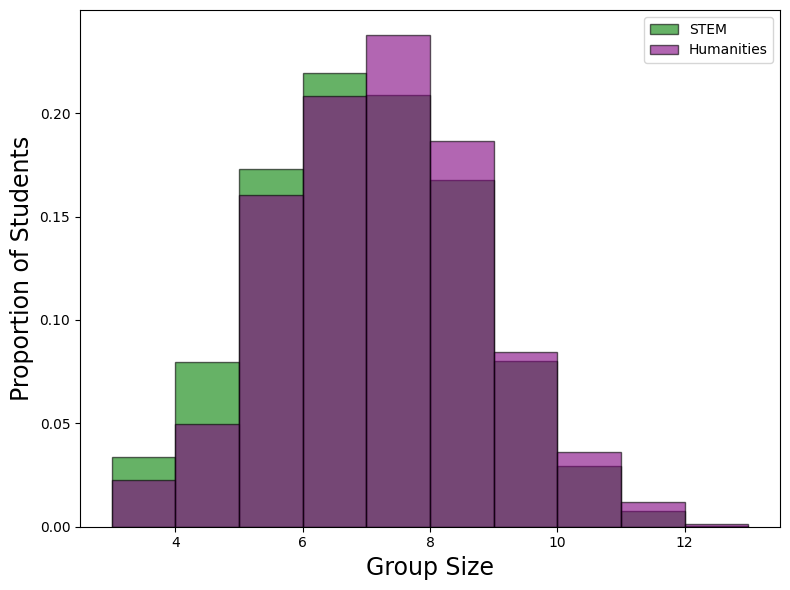

In [24]:
# Define STEM and Humanities subjects
stem_subjects = [
    'Mathematical Tripos', 'Natural Sciences Tripos', 'Engineering Tripos',
    'Computer Science Tripos', 'Chem Eng via Engineering', 'Chem Eng via Nat Sciences',
    'Medicine', 'Veterinary Medicine'
]
humanities_subjects = [
    'English Tripos', 'History of Art Tripos', 'Historical Tripos',
    'Philosophy Tripos', 'Classical Tripos', 'Classical Tripos Four Year',
    'Mod & Med Langs Tripos', 'Music Tripos', 'Linguistics Tripos',
    'Asian & Middle Eastern Studies', 'Archaeology Tripos', 'ASNC Tripos',
    'Theo,Relig,&Philo of Re Tripos', 'Theol for Ministry Exam',
    'History and Mod Lang Tripos', 'History & Politics Tripos', 'Education Tripos'
]

stem_mask = students_df['Subject'].isin(stem_subjects)
human_mask = students_df['Subject'].isin(humanities_subjects)

stem_sizes = students_df.loc[stem_mask, 'Group Size']
human_sizes = students_df.loc[human_mask, 'Group Size']

plt.figure(figsize=(8, 6))
bins = range(int(students_df['Group Size'].min()), int(students_df['Group Size'].max()) + 2)

plt.hist(stem_sizes, bins=bins, alpha=0.6, label='STEM', color='green', edgecolor='black', density=True)
plt.hist(human_sizes, bins=bins, alpha=0.6, label='Humanities', color='purple', edgecolor='black', density=True)

plt.xlabel('Group Size', fontsize=17)
plt.ylabel('Proportion of Students', fontsize=17)
plt.legend()
#plt.title('Normalized Group Size Distribution: STEM vs Humanities', fontsize=16)
plt.tight_layout()
plt.show()

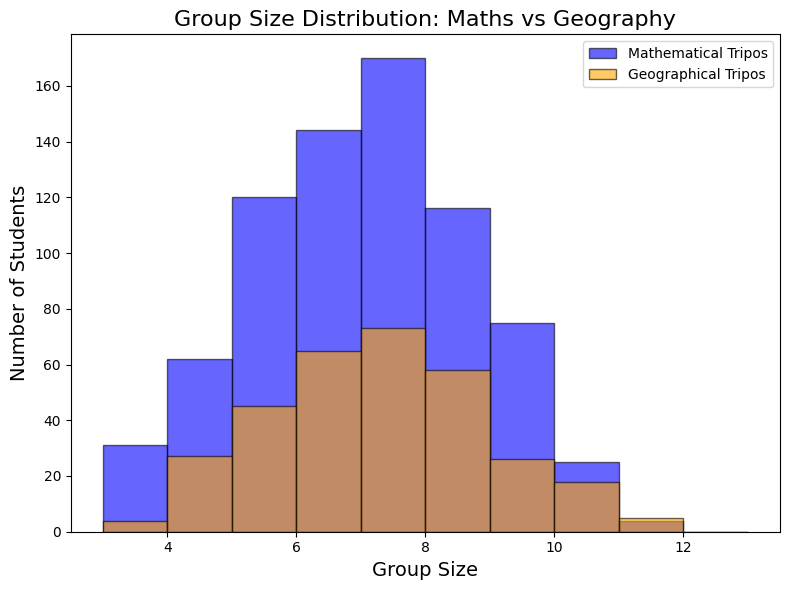

In [ ]:
# Filter for Maths and Geography students


plt.figure(figsize=(8, 6))
plt.hist(maths_sizes, bins=range(int(students_df['Group Size'].min()), int(students_df['Group Size'].max()) + 2),
         alpha=0.6, label='Mathematical Tripos', color='blue', edgecolor='black')
plt.hist(geog_sizes, bins=range(int(students_df['Group Size'].min()), int(students_df['Group Size'].max()) + 2),
         alpha=0.6, label='Geographical Tripos', color='orange', edgecolor='black')
plt.xlabel('Group Size', fontsize=14)
plt.ylabel('Number of Students', fontsize=14)
plt.legend()
plt.title('Group Size Distribution: Maths vs Geography', fontsize=16)
plt.tight_layout()
plt.show()

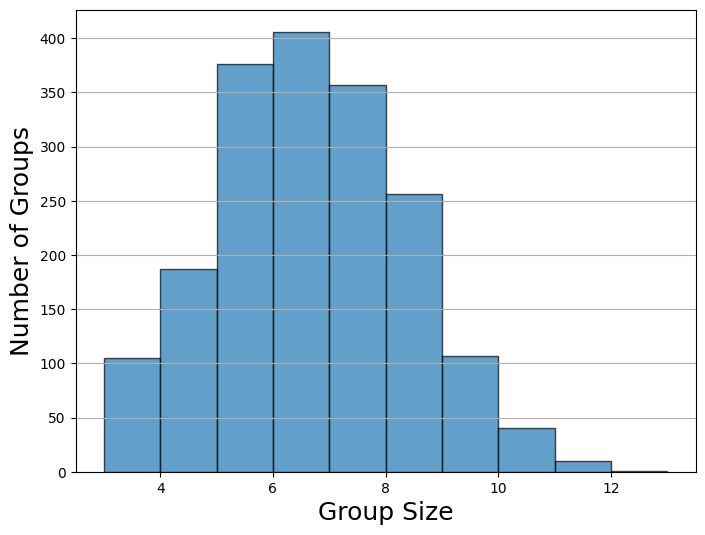

In [19]:
# Calculate average group size (should be the same as 'Group Size' for each group)
avg_group_size = students_df.groupby('Group ID')['Group Size'].first()

plt.figure(figsize=(8, 6))
plt.hist(avg_group_size, bins=range(int(avg_group_size.min()), int(avg_group_size.max()) + 2), edgecolor='black', alpha=0.7)
plt.xlabel('Group Size', fontsize=18)
plt.ylabel('Number of Groups', fontsize=18)
#plt.title('Histogram of Group Sizes')
plt.grid(axis='y')
plt.show()
